In [1]:
import cv2
import numpy as np
from tqdm import tqdm
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.spatial import distance
from sklearn.cluster import KMeans
from skimage.segmentation import slic
from rasterio.features import rasterize
from rasterio.transform import from_origin
from sklearn.metrics import confusion_matrix
from shapely.geometry import Polygon, MultiPolygon
from skimage.feature import graycomatrix, graycoprops
import warnings

warnings.filterwarnings("ignore")

# Load the GeoJSON file into a GeoDataFrame
geo_df = gpd.read_file('labels.geojson')
# Show the first few rows of the GeoDataFrame
geo_df.head()


,fid,SHAPE_AREA,SHAPE_LEN,crop_id,crop_name,geometry
0,54,4400.70910,293.870062,9,Forage Crops,"MULTIPOLYGON (((449042.600 5827711.200, 449082..."
1,3935,299598.99930,2574.818018,1,Wheat,"MULTIPOLYGON (((455395.090 5828098.210, 455395..."
2,4073,194110.48135,1913.745250,1,Wheat,"MULTIPOLYGON (((452593.690 5827525.940, 452580..."
3,4724,15059.00790,1181.569204,8,Meadows,"MULTIPOLYGON (((433352.160 5819538.890, 433376..."
4,5336,75017.01935,1506.996389,2,Rye,"MULTIPOLYGON (((454516.350 5826887.890, 454531..."


In [2]:
total_bounds = geo_df.geometry.total_bounds
minx, miny, maxx, maxy = total_bounds

img_shape = (2400, 2400)
# Determine the scaling factors for x and y dimensions
x_range = maxx - minx
y_range = maxy - miny

x_factor = img_shape[1] / x_range
y_factor = img_shape[0] / y_range

In [3]:
def normalize_and_scale_geometry(geometry, minx, miny, x_factor, y_factor):
    """
    Normalize and scale a single geometry (Polygon or MultiPolygon).
    """
    if isinstance(geometry, Polygon):
        return Polygon([(x - minx) * x_factor, (y - miny) * y_factor] for x, y in geometry.exterior.coords)
    elif isinstance(geometry, MultiPolygon):
        new_polys = []
        for poly in geometry.geoms:
            new_poly = Polygon([(x - minx) * x_factor, (y - miny) * y_factor] for x, y in poly.exterior.coords)
            new_polys.append(new_poly)
        return MultiPolygon(new_polys)
    else:
        return geometry

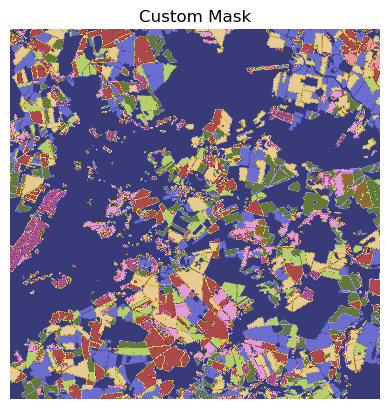

In [4]:
# Load the GeoJSON file into a GeoDataFrame
geo_df = gpd.read_file('labels.geojson')

# Determine the bounding box of all the geometries
total_bounds = geo_df.geometry.total_bounds
minx, miny, maxx, maxy = total_bounds

# Determine the scaling factors for x and y dimensions
x_range = maxx - minx
y_range = maxy - miny

x_factor = img_shape[1] / x_range
y_factor = img_shape[0] / y_range

# Normalize and scale the geometries
normalized_geo_df = geo_df.copy()
normalized_geo_df['geometry'] = normalized_geo_df['geometry'].apply(
    lambda geom: normalize_and_scale_geometry(geom, minx, miny, x_factor, y_factor)
)

def custom_mask_from_geodataframe(gdf, img_shape, value_column='crop_id'):
    """
    Create a custom mask from a GeoDataFrame based on the provided value_column.
    This method ensures that the rasterized values are directly from the value_column.
    Areas not covered by any geometry will have a value of -1.
    
    Parameters:
        gdf (GeoDataFrame): The GeoDataFrame containing the polygons.
        img_shape (tuple): The shape of the image for which to create a mask.
        value_column (str): The column in the GeoDataFrame that contains the values to use for the mask.
    
    Returns:
        np.ndarray: The created mask.
    """
    # Create a mask filled with -1
    mask = np.full(img_shape, -1, dtype=np.int16)
    
    # Define the rasterize shapes and values
    shapes = [(geom, value) for geom, value in zip(gdf.geometry, gdf[value_column])]
    
    # Rasterize the geometries
    mask = rasterize(shapes, out_shape=img_shape, fill=0, transform=from_origin(0, img_shape[0], 1, 1), dtype=np.int16)
    
    return mask

# Create custom masks for VV and VH images using the defined function
mask = custom_mask_from_geodataframe(normalized_geo_df, img_shape, value_column='crop_id')

# Display the custom masks
plt.imshow(mask, cmap='tab20b', vmin=0)
plt.title('Custom Mask')
plt.axis('off')

plt.show()


In [5]:
print(np.unique(mask))

[0 1 2 3 4 5 6 7 8 9]


In [6]:
vh = np.load('vh.npy')
print(vh.shape, "vh")

vv = np.load('vv.npy')
print(vv.shape, "vv")

(122, 2400, 2400, 1) vh
(122, 2400, 2400, 1) vv


In [7]:
vh_imgs = np.log(vh[:, :, :, 0] + 1e+1) / np.log(10) * mask
vv_imgs = np.log(vv[:, :, :, 0] + 1e+1) / np.log(10) * mask

In [8]:
# Flatten the 2D images
vh_flat = vh_imgs[0].reshape((-1, 1))
vv_flat = vv_imgs[0].reshape((-1, 1))

# Concatenate these along the feature dimension
features = np.concatenate([vh_flat, vv_flat], axis=1)

# Check for infinite values and replace them with NaN
features[np.isinf(features)] = np.nan

# Replace NaN values with the mean of the array
features[np.isnan(features)] = np.nanmean(features)

# Replace very large values with the maximum finite value
large_values = np.isfinite(features)
max_finite = np.max(features[large_values])
features[~large_values] = max_finite


In [9]:
# Perform K-means clustering
n_clusters = 10  # Number of clusters; can be changed based on needs
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(features)
labels = kmeans.labels_

# Reshape labels back to 2D image shape
segmented_vh = labels.reshape(vh_imgs[0].shape[:2])
segmented_vv = labels.reshape(vv_imgs[0].shape[:2])


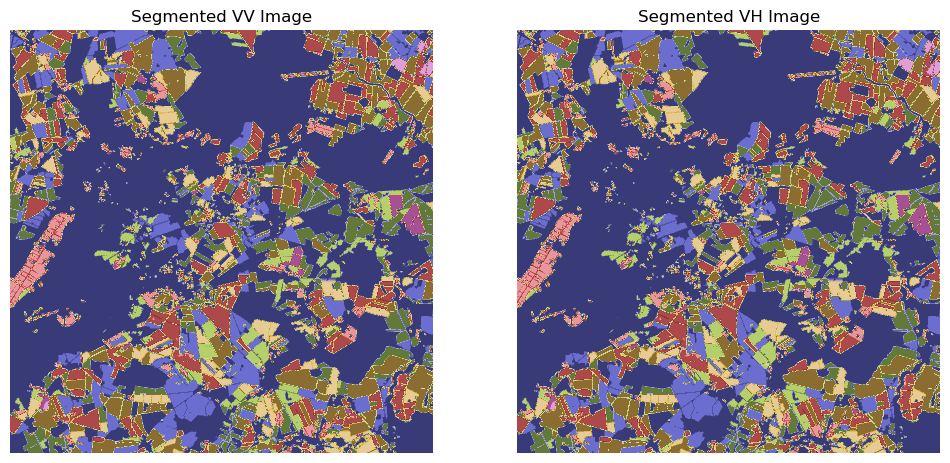

In [10]:
# plot the segmented images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(segmented_vh, cmap='tab20b')
axes[0].set_title('Segmented VV Image')
axes[0].axis('off')

axes[1].imshow(segmented_vv, cmap='tab20b')
axes[1].set_title('Segmented VH Image')
axes[1].axis('off')

plt.show()

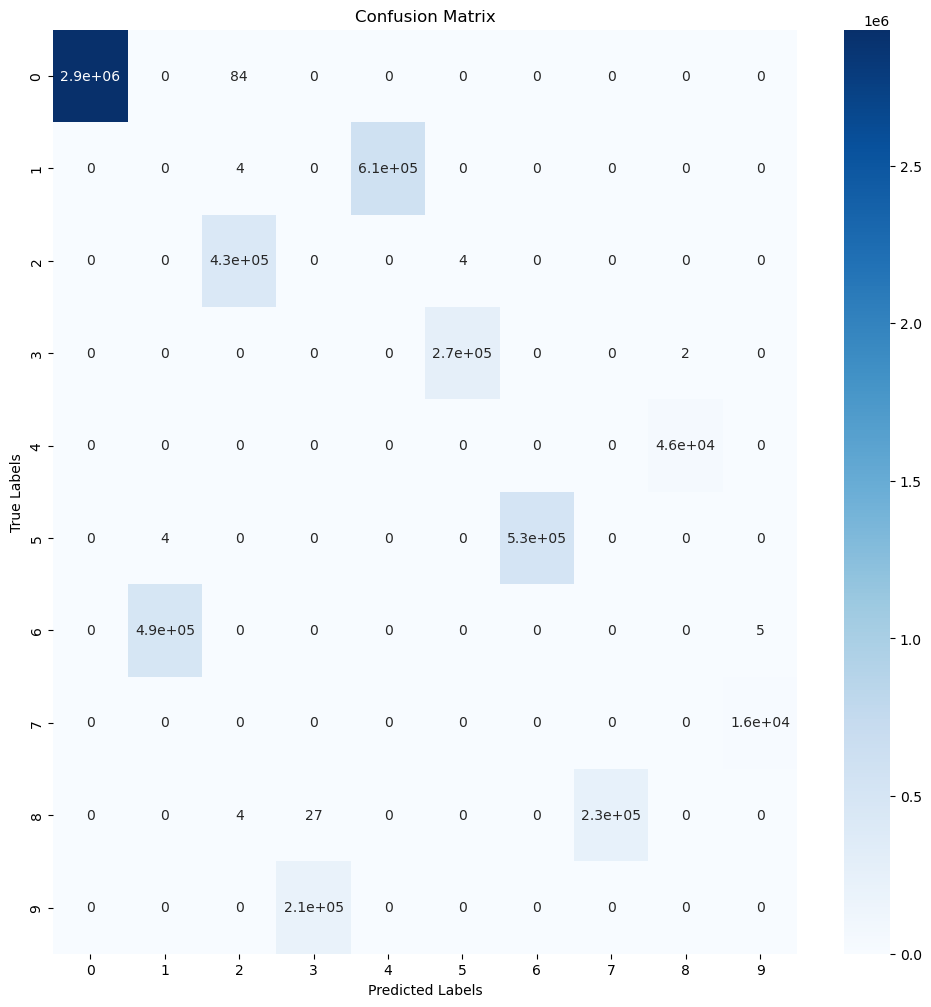

In [11]:
cf = confusion_matrix(mask.flatten(), segmented_vv.flatten())

# plot the confusion matrix
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(cf, annot=True, ax=ax, cmap='Blues')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
plt.show()



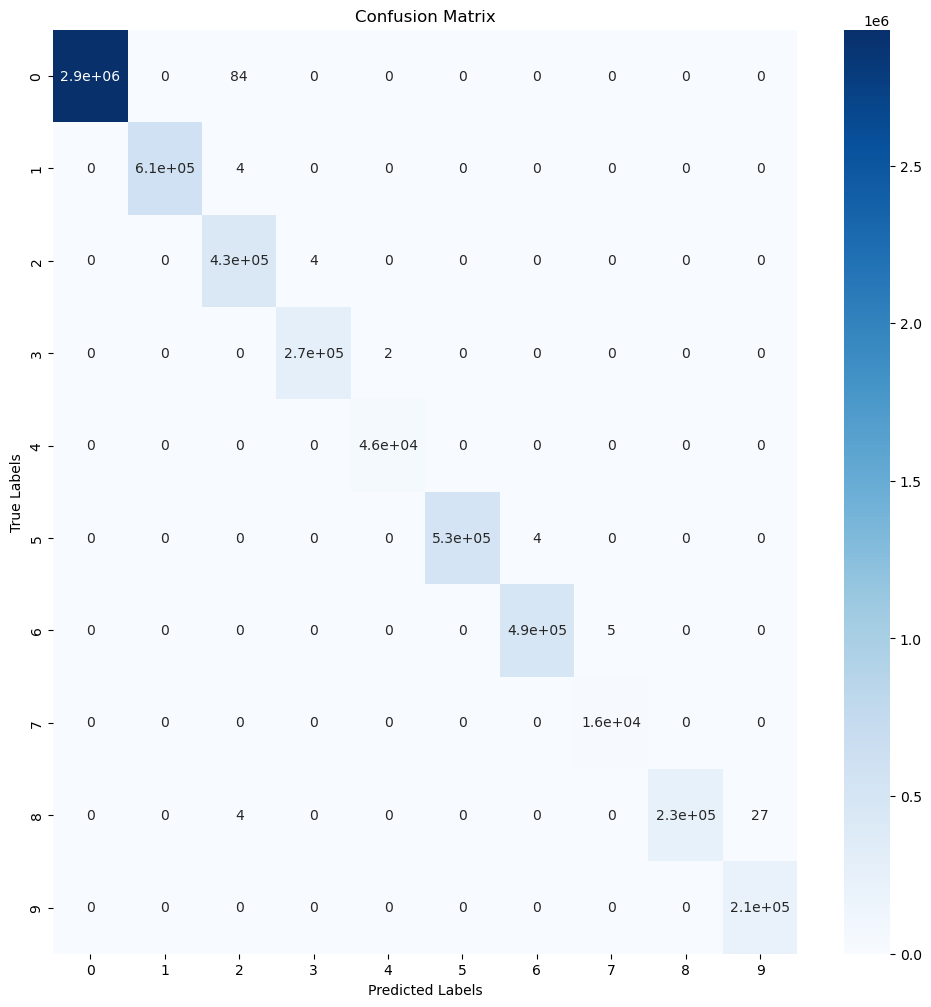

In [12]:
cf_transposed = cf.T

# create a dictionary to map the labels
map_dict = {}
for i in range(len(cf_transposed)):
    map_dict[i] = np.argmax(cf_transposed[i])

# map the labels
mapped_labels = np.vectorize(map_dict.get)(segmented_vv)

# Get the confusion matrix for the mapped labels
cf_mapped = confusion_matrix(mask.flatten(), mapped_labels.flatten())

# plot the confusion matrix
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(cf_mapped, annot=True, ax=ax, cmap='Blues')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
plt.show()


In [13]:
# Create a function to perform the K-means clustering
def kmeans_clustering(features, n_clusters=10, reshape = vh_imgs[0].shape[:2]):
    """
    Perform K-means clustering on the provided features.
    
    Parameters:
        features (np.ndarray): The features to use for clustering.
        n_clusters (int): The number of clusters to use.
    
    Returns:
        np.ndarray: The segmented image.
    """
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(features)
    labels = kmeans.labels_

    # Reshape labels back to 2D image shape
    segmented = labels.reshape(reshape)
    
    return segmented

# Create a function to create a confusion matrix
def create_confusion_matrix(true_mask, segmented):
    """
    Create a confusion matrix for the provided true mask and segmented image.
    
    Parameters:
        true_mask (np.ndarray): The true mask.
        segmented (np.ndarray): The segmented image.
    
    Returns:
        np.ndarray: The confusion matrix.
    """
    cf = confusion_matrix(true_mask.flatten(), segmented.flatten())
    
    cf_transposed = cf.T

    # Matching the labels to the true mask
    label_map = {}
    for i in range(len(cf_transposed)):
        label_map[i] = np.argmax(cf_transposed[i])

    # Remap the labels
    remapped_segmented = np.vectorize(label_map.get)(segmented)

    # Create a confusion matrix for the remapped labels
    cf = confusion_matrix(true_mask.flatten(), remapped_segmented.flatten())
    
    return cf

# Create a function to plot the confusion matrix
def plot_confusion_matrix(cf):
    """
    Plot the provided confusion matrix.
    
    Parameters:
        cf (np.ndarray): The confusion matrix.
    """
    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(12, 12))
    sns.heatmap(cf, annot=True, ax=ax, cmap='Blues')
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    plt.show()

# Create a function to perform the K-means clustering, create a confusion matrix, and plot the confusion matrix
def kmeans_clustering_and_confusion_matrix(features, true_mask, n_clusters=10):
    """
    Perform K-means clustering on the provided features, create a confusion matrix, and plot the confusion matrix.
    
    Parameters:
        features (np.ndarray): The features to use for clustering.
        true_mask (np.ndarray): The true mask.
        n_clusters (int): The number of clusters to use.
    """
    # Perform K-means clustering
    segmented = kmeans_clustering(features, n_clusters=n_clusters)
    
    # Create a confusion matrix
    cf = create_confusion_matrix(true_mask, segmented)
    return cf

# Create a function to iterate over all the images and create a confusion matrix for each image and combine them
def create_combined_confusion_matrix(features_list, true_mask, n_clusters=10):
    """
    Iterate over all the images and create a confusion matrix for each image and combine them.
    
    Parameters:
        features_list (list): A list of features to use for clustering.
        true_mask (np.ndarray): The true mask.
        n_clusters (int): The number of clusters to use.
    
    Returns:
        np.ndarray: The combined confusion matrix.
    """
    # Create an empty confusion matrix
    combined_cf = np.zeros((n_clusters, n_clusters))
    
    # Iterate over the features
    for features in tqdm(features_list):
        # Perform K-means clustering and create a confusion matrix
        cf = kmeans_clustering_and_confusion_matrix(features, true_mask, n_clusters=n_clusters)
        # Add the confusion matrix to the combined confusion matrix
        combined_cf += cf
    
    return combined_cf

def get_features(imageIndex):
    # Flatten the 2D images
    vh_flat = vh_imgs[imageIndex].reshape((-1, 1))
    vv_flat = vv_imgs[imageIndex].reshape((-1, 1))

    # Concatenate these along the feature dimension
    features = np.concatenate([vh_flat, vv_flat], axis=1)

    # Check for infinite values and replace them with NaN
    features[np.isinf(features)] = np.nan

    # Replace NaN values with the mean of the array
    features[np.isnan(features)] = np.nanmean(features)

    # Replace very large values with the maximum finite value
    large_values = np.isfinite(features)
    max_finite = np.max(features[large_values])
    features[~large_values] = max_finite
    return features

Creating a list of features to use for clustering
Creating the combined confusion matrix


100%|██████████████████████████████████████████████████████████████████████████████| 122/122 [1:21:58<00:00, 40.32s/it]


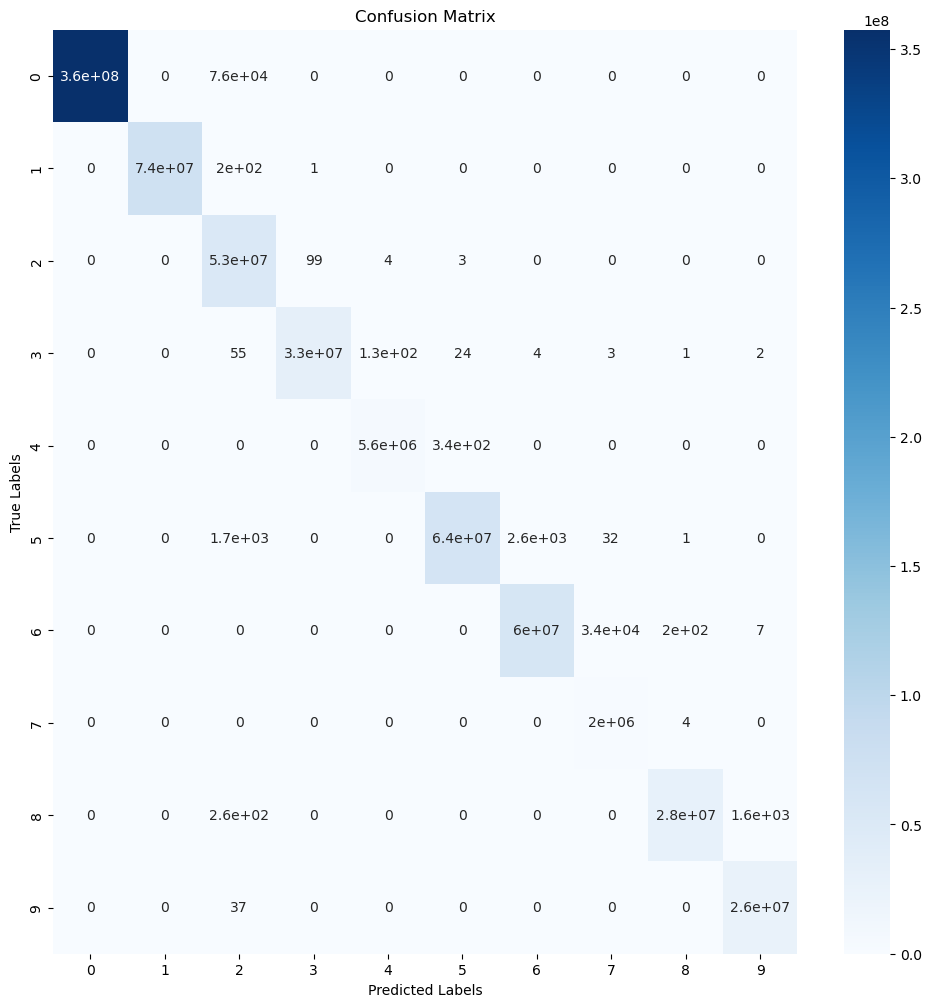

In [14]:
print("Creating a list of features to use for clustering")
# Create a list of features to use for clustering
features_list = []
imageIndex = 0
while imageIndex < vh_imgs.shape[0]:
    features = get_features(imageIndex)
    features_list.append(features)
    imageIndex += 1

print("Creating the combined confusion matrix")
# Create the combined confusion matrix
combined_cf = create_combined_confusion_matrix(features_list, mask, n_clusters=10)

# Plot the combined confusion matrix
plot_confusion_matrix(combined_cf)

In [15]:
# Calculate the accuracy percentage
accuracy_percentage = np.sum(combined_cf.diagonal()) / np.sum(combined_cf)
print(f'Accuracy Percentage: {accuracy_percentage * 100:.2f}%')

Accuracy Percentage: 99.98%


In [33]:
def split_into_grids(img, grid_size):
    grids = []
    img_height, img_width = img.shape[:2]
    for i in range(0, img_height, grid_size):
        for j in range(0, img_width, grid_size):
            grids.append(img[i:i+grid_size, j:j+grid_size])
    return grids

In [34]:
def apply_slic(grid, n_segments, compactness=10.0, sigma=1):
    segments = slic(grid, n_segments=n_segments, compactness=compactness, sigma=sigma, start_label=1, channel_axis=None)
    return segments
# image segmentation, dividing an image into regions based on color similarity


In [35]:
def get_features_for_grid(grid):
    shape = grid.shape
    # Flatten the 2D grid
    grid = grid.reshape(-1,1)
    
    # Check for infinite values and replace them with NaN
    grid[np.isinf(grid)] = np.nan

    # Replace NaN values with the mean of the array
    grid[np.isnan(grid)] = np.nanmean(grid)

    # Replace very large values with the maximum finite value
    large_values = np.isfinite(grid)
    max_finite = np.max(grid[large_values])
    grid[~large_values] = max_finite

    grid = grid.reshape(shape)
    
    return grid


In [36]:
def auto_canny_threshold(grid, sigma=0.33):
    """
    Compute the median of the single channel pixel intensities
    and set lower and upper thresholds based on the sigma value.
    """
    v = np.median(grid)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    return lower, upper

#  Edge detection based on CANNY, SOBEL or Mexican hat

In [37]:
def calculate_histogram(image):
    """
    Calculate the histogram of an image.
    """
    histogram = cv2.calcHist([image], [0], None, [256], [0,256])
    return cv2.normalize(histogram, histogram)

def calculate_hog(image):
    """
    Calculate the Histogram of Oriented Gradients (HOG) of an image.
    """
    winSize = (20, 20)
    blockSize = (10, 10)
    blockStride = (5, 5)
    cellSize = (10, 10)
    nbins = 9
    hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)
    return hog.compute(image)

def calculate_glcm(image):
    """
    Calculate the Grey Level Co-occurrence Matrix (GLCM) of an image.
    """
    glcm = graycomatrix(image, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')
    return contrast

def compare_segments(segment1, segment2):
    """
    Compare two segments using histogram, HOG, and GLCM.
    Returns True if segments are similar, False otherwise.
    """
    # Calculate histograms
    hist1, hist2 = calculate_histogram(segment1), calculate_histogram(segment2)
    hist_diff = distance.euclidean(hist1.flatten(), hist2.flatten())

    # Calculate HOG features
    hog1, hog2 = calculate_hog(segment1.astype(np.uint8)), calculate_hog(segment2.astype(np.uint8))
    hog_diff = distance.euclidean(hog1.flatten(), hog2.flatten())

    # Calculate GLCM features
    glcm1, glcm2 = calculate_glcm(segment1.astype(np.uint8)), calculate_glcm(segment2.astype(np.uint8))
    glcm_diff = np.abs(glcm1 - glcm2).sum()

    # Define thresholds for similarity(how)
    hist_threshold = 0.3  # Adjust as needed
    hog_threshold = 0.3   # Adjust as needed
    glcm_threshold = 5.0  # Adjust as needed

    # Check if all features are within their respective thresholds
    if hist_diff < hist_threshold and hog_diff < hog_threshold and glcm_diff < glcm_threshold:
        return True
    else:
        return False


In [38]:
def extract_segments_at_intersection(grid, slic_segment, canny_edges):
    """
    Extracts segments at the intersection of a SLIC segment and Canny edges.

    :param grid: The entire grid (image) on which operations are being performed.
    :param slic_segment: A boolean mask representing a single SLIC segment.
    :param canny_edges: The result of Canny edge detection on the grid.
    :return: Two segments - one inside the Canny edges and one outside.
    """

    # Create a mask for the intersection of the SLIC segment and Canny edges
    intersection_mask = np.logical_and(slic_segment, canny_edges)

    # Extract the segment inside the Canny edges
    segment_inside = np.where(intersection_mask, grid, 0)

    # Extract the segment outside the Canny edges
    segment_outside = np.where(np.logical_and(slic_segment, np.logical_not(canny_edges)), grid, 0)

    return segment_inside, segment_outside


In [39]:
def find_slic_boundary(slic_segment):
    """
    Finds the boundary of a SLIC segment.

    :param slic_segment: A binary mask representing a single SLIC segment.
    :return: A binary mask with the boundary of the SLIC segment.
    """
    # Convert the SLIC segment to the correct format if necessary
    slic_segment_uint8 = slic_segment.astype(np.uint8) * 255

    # Dilate the SLIC segment
    kernel = np.ones((3, 3), np.uint8)
    dilated_segment = cv2.dilate(slic_segment_uint8, kernel, iterations=1)

    # Find the boundary by subtracting the original segment from the dilated one
    boundary = dilated_segment - slic_segment_uint8

    # Convert the boundary to a binary mask
    boundary_mask = (boundary > 0).astype(np.uint8)

    return boundary_mask
    # you can use the median of pixels within each closed boundary found in step 2 and consider it as an object centroid

In [40]:
grid_size = 25
grids = split_into_grids(vh_imgs[0], grid_size)  # Using the vh image as an example
mask_grids = split_into_grids(mask, grid_size)

updated_canny_edges_list = []

for grid, mask_grid in zip(grids, mask_grids):
    grid = get_features_for_grid(grid)

    # Apply SLIC segmentation
    slic_segments = apply_slic(grid, n_segments=20, compactness=0.5)

    # Determine Canny edge thresholds and apply Canny edge detection
    lower_thresh, upper_thresh = auto_canny_threshold(grid)
    canny_edges = cv2.Canny(grid.astype(np.uint8), lower_thresh, upper_thresh)

    # Initialize an empty mask to update the divided Canny segments
    updated_canny_edges = np.zeros_like(canny_edges)

    flag = False
    # Logic to identify intersections and compare segments
    for slic_label in np.unique(slic_segments):
        slic_segment = (slic_segments == slic_label)

        # Determine if this SLIC segment intersects with any Canny edges
        intersects = np.any(np.logical_and(slic_segment, canny_edges))
        flag = True
        if intersects:
            # Extract segments at intersection
            # Implement extract_segments_at_intersection
            segment1, segment2 = extract_segments_at_intersection(grid, slic_segment, canny_edges)

            # Compare segments
            if not compare_segments(segment1, segment2):
                # Logic to divide the Canny segment along the SLIC line
                slic_boundary = find_slic_boundary(slic_segment)
                updated_canny_edges = np.logical_or(updated_canny_edges, slic_boundary)
            else:
                # If segments are similar, keep the original Canny edges for this segment
                updated_canny_edges = np.logical_or(updated_canny_edges, canny_edges * slic_segment)
    if flag:
        # Append the updated Canny edges for this grid to the list
        updated_canny_edges_list.append(updated_canny_edges)
    else:
        updated_canny_edges_list.append(canny_edges)



In [41]:
def reassemble_grids(grids, original_shape):
    """
    Reassemble a list of grids into a single image.
    
    :param grids: List of processed grid images.
    :param original_shape: Original shape of the image before it was split into grids.
    :return: Reassembled image.
    """
    num_rows = original_shape[0] // grid_size
    num_cols = original_shape[1] // grid_size

    rows = [np.concatenate(grids[row_idx*num_cols:(row_idx+1)*num_cols], axis=1) for row_idx in range(num_rows)]
    full_image = np.concatenate(rows, axis=0)

    return full_image

# Example usage
reassembled_image = reassemble_grids(grids, vh_imgs[0].shape)
reassembled_edge_map = (reassemble_grids(updated_canny_edges_list, vh_imgs[0].shape) * 255).astype(np.uint8)

In [42]:
contours, _ = cv2.findContours(reassembled_edge_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
glcm_features = []
for contour in contours:
    # Create mask for contour
    mask = np.zeros(reassembled_edge_map.shape, dtype=np.uint8)
    cv2.drawContours(mask, [contour], -1, (255), thickness=cv2.FILLED)

    # Extract the region within the contour
    region = cv2.bitwise_and(reassembled_image, reassembled_image, mask=mask)

    # Calculate GLCM features for this region
    glcm_feature = calculate_glcm(region.astype(np.uint8))
    glcm_features.append(glcm_feature.sum())

In [43]:
data = np.array(glcm_features).reshape(-1, 1)
# Cluster contours based on GLCM features
kmeans = KMeans(n_clusters=10, random_state=0).fit(data)
# Get the cluster assignment for each number
labels = kmeans.labels_

In [44]:
# Create an image to visualize the clustering
labelled_image = np.zeros_like(reassembled_image)

for label, contour in zip(labels, contours):
    cv2.drawContours(labelled_image, [contour], -1, int(label * 255 / 9), thickness=cv2.FILLED)


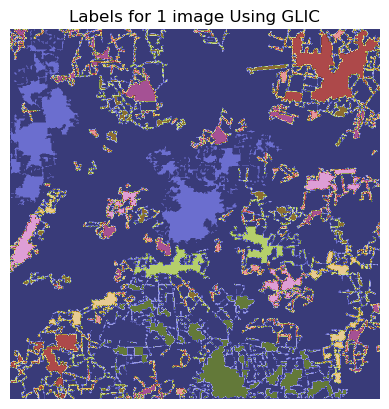

In [45]:
plt.imshow(labelled_image, cmap='tab20b', vmin=0)
plt.title('Labels for 1 image Using GLIC')
plt.axis('off')

plt.show()

In [46]:
std_devs = []

for contour in contours:
    # Create a mask for the contour
    mask = np.zeros(reassembled_edge_map.shape, dtype=np.uint8)
    cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)

    # Extract the region inside the contour
    masked_region = np.ma.masked_array(reassembled_image, mask=mask==0)

    # Calculate and store the standard deviation
    std_dev = np.ma.std(masked_region)
    if str(type(std_dev)) == "<class 'numpy.ma.core.MaskedConstant'>":
        std_dev = 0
    else:
        std_dev = int(std_dev)
    std_devs.append(std_dev)


In [47]:
# Reshape the list of standard deviations for KMeans
std_devs_array = np.array(std_devs).reshape(-1, 1)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=10, random_state=0).fit(std_devs_array)
labels = kmeans.labels_


In [48]:
# Create an image to visualize the clustering
labelled_image = np.zeros_like(reassembled_image, dtype=np.uint8)

for label, contour in zip(labels, contours):
    cv2.drawContours(labelled_image, [contour], -1, int(label * 255 / 9), thickness=cv2.FILLED)

# Display or save the labeled image
# For example, using cv2.imshow or cv2.imwrite


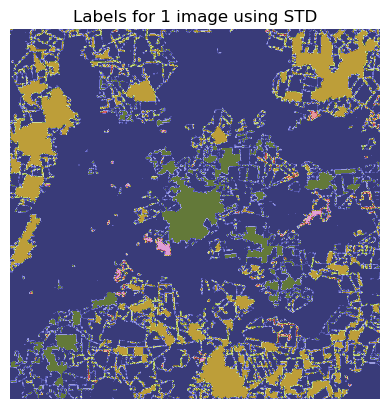

In [49]:
plt.imshow(labelled_image, cmap='tab20b', vmin=0)
plt.title('Labels for 1 image using STD')
plt.axis('off')

plt.show()